In [ ]:
## import libraries

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


original code downloaded from:

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=7rZnJaGTWQw0

In [ ]:
## This tutorial will just deal with hourly predictions, 
## so start by sub-sampling the data from 10-minute intervals to one-hour intervals


df = pd.read_csv('b46059_historical_2020.csv')

#df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M')

## take a glance at the data

df.head()



,WDIR (degT),WSPD (m/s),WVHT (m),DPD (sec),APD (sec),PRES (hPa)
0,308.0,9.1,4.20,23.5,10.2,1028.5
1,309.0,8.0,3.69,21.1,9.3,1028.2
2,309.0,9.0,4.46,21.1,10.8,1028.8
3,302.0,7.9,4.71,21.1,10.9,1028.8
4,295.0,7.2,5.44,21.1,12.2,1028.8


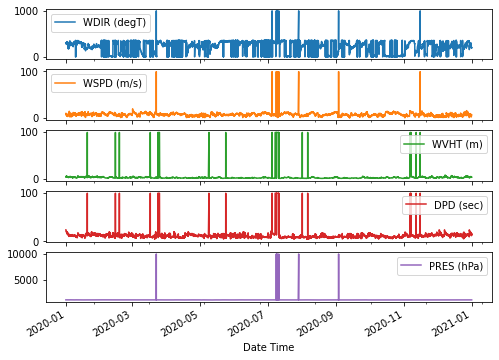

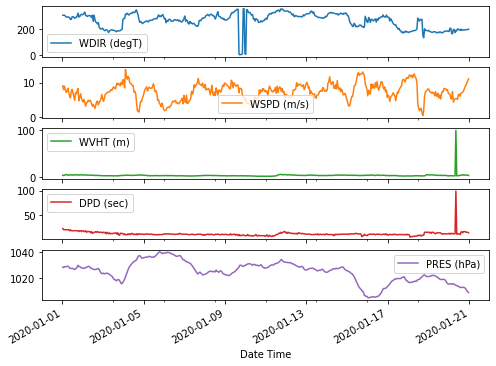

In [ ]:
### a few plots

plot_cols = ['WDIR (degT)','WSPD (m/s)','WVHT (m)','DPD (sec)','PRES (hPa)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)


In [ ]:
### take a look into statistics

df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
WDIR (degT),8708.0,217.532843,130.501103,1.00,78.00,253.00,334.00,999.0
WSPD (m/s),8708.0,6.896222,4.048456,0.00,4.90,6.70,8.80,99.0
WVHT (m),8708.0,3.592316,10.230673,0.77,1.75,2.32,3.14,99.0
DPD (sec),8708.0,12.133992,9.728950,4.20,9.10,10.80,12.90,99.0
APD (sec),8708.0,8.282212,9.789237,4.50,6.20,7.00,8.10,99.0
PRES (hPa),8708.0,1029.515136,254.485354,997.60,1019.10,1022.30,1025.80,9999.0


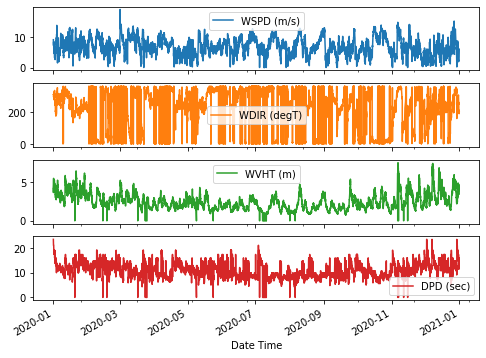

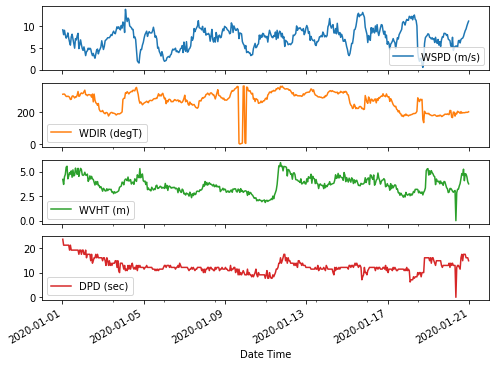

In [ ]:
### find NaNs and replace

wv = df['WSPD (m/s)']
bad_wv = wv == 99.0

wd = df['WDIR (degT)']
bad_wd = wd == 999.0

df['WSPD (m/s)'][bad_wv] = 0.0
df['WDIR (degT)'][bad_wd] = 0.0

wh = df['WVHT (m)']
bad_wh = wh == 99.0

dp = df['DPD (sec)']
bad_dp = dp == 99.0

df['WVHT (m)'][bad_wh] = 0.0
df['DPD (sec)'][bad_dp] = 0.0

plot_cols = ['WSPD (m/s)','WDIR (degT)','WVHT (m)','DPD (sec)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)


Text(0, 0.5, 'Wind Velocity [m/s]')

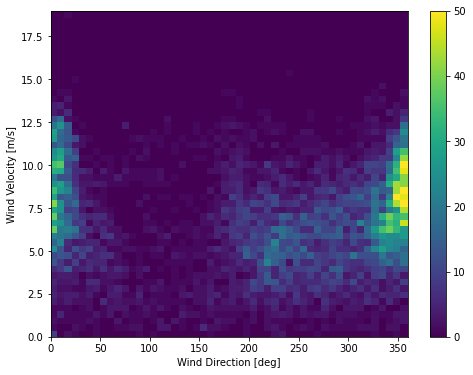

In [ ]:
## Before diving in to build a model, it's important to understand your data and be sure that 
## you're passing the model appropriately formatted data.

## Wind

## The last column of the data, wd (deg)—gives the wind direction in units of degrees. 
## Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. 
## Direction shouldn't matter if the wind is not blowing.

## Right now the distribution of wind data looks like this:

plt.hist2d(wd, wv, bins=(50, 50), vmax=50)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')



In [ ]:
## But this will be easier for the model to interpret if you convert the wind direction 
## and velocity columns to a wind vector:

wv = df.pop('WSPD (m/s)')
max_wv = wv.max()

# Convert to radians.
wd_rad = df.pop('WDIR (degT)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)



(-14.1, 17.738028103446833, -13.294219548518818, 12.179625809815441)

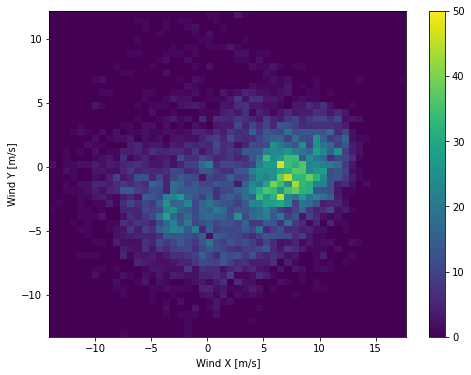

In [ ]:
## The distribution of wind vectors is much simpler for the model to correctly interpret

plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=50)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')



In [ ]:
## Similarly, the Date Time column is very useful, but not in this string form. 
## Start by converting it to seconds

timestamp_s = date_time.map(pd.Timestamp.timestamp)



In [ ]:
## Similar to the wind direction, the time in seconds is not a useful model input. 
## Being weather data, it has clear daily and yearly periodicity. There are many ways 
## you could deal with periodicity.

## You can get usable signals by using sine and cosine transforms to clear 
## "Time of day" and "Time of year" signals:

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Text(0.5, 1.0, 'Time of day signal')

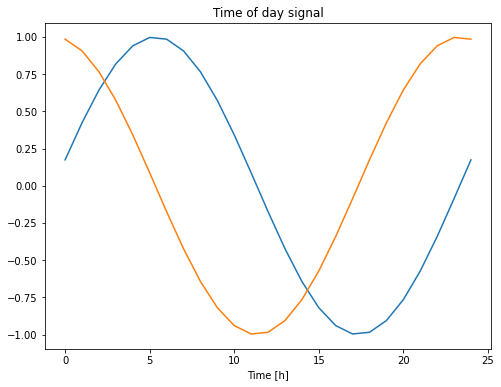

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')


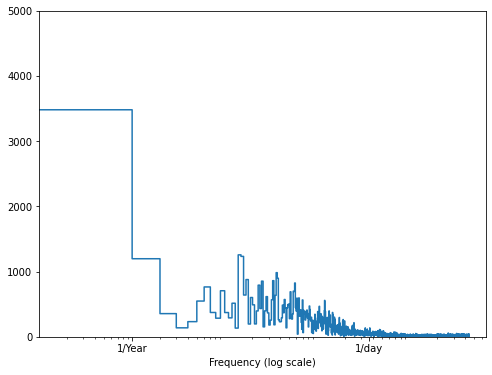

In [ ]:
## This gives the model access to the most important frequency features. 
## In this case you knew ahead of time which frequencies were important.

## If you don't have that information, you can determine which frequencies are 
## important by extracting features with Fast Fourier Transform. To check the 
## assumptions, here is the tf.signal.rfft of the temperature over time. Note the 
## obvious peaks at frequencies near 1/year and 1/day

fft = tf.signal.rfft(df['WVHT (m)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['WVHT (m)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 5000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')



In [ ]:
## Split the data

## You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. 
## Note the data is not being randomly shuffled before splitting. This is for two reasons:

##    It ensures that chopping the data into windows of consecutive samples is still possible.
##    It ensures that the validation/test results are more realistic, being evaluated on the data 
##       collected after the model was trained.


column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]



In [ ]:
## Normalize the data

## It is important to scale features before training a neural network. Normalization is a 
## common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

## The mean and standard deviation should only be computed using the training data so that the models have 
## no access to the values in the validation and test sets.

## It's also arguable that the model shouldn't have access to future values in the training set when 
## training, and that this normalization should be done using moving averages. That's not the focus of this 
## tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest 
## of simplicity this tutorial uses a simple average.

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std



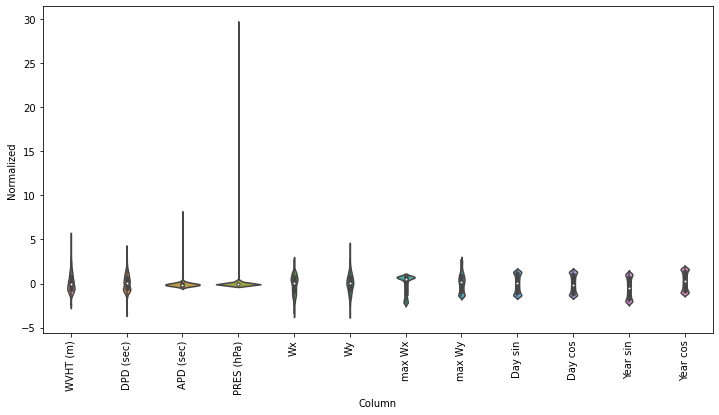

In [ ]:
## Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious 
## errors like the -9999 wind velocity value.

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)



In [ ]:
## Data windowing

## The models in this tutorial will make a set of predictions based on a window of 
## consecutive samples from the data.

## The main features of the input windows are:

##    The width (number of time steps) of the input and label windows.
##    The time offset between them.
##    Which features are used as inputs, labels, or both.

## This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), 
## and uses them for both:

##    Single-output, and multi-output predictions.
##    Single-time-step and multi-time-step predictions.

## This section focuses on implementing the data windowing so that it can be reused for 
## all of those models. Depending on the task and type of model you may want to generate a 
## variety of data windows.

## The rest of this section defines a WindowGenerator class. This class can:

##    Handle the indexes and offsets as shown in the diagrams above.
##    Split windows of features into (features, labels) pairs.
##    Plot the content of the resulting windows.
##    Efficiently generate batches of these windows from the training, evaluation, 
##    and test data, using tf.data.Datasets.

#######################################

#### 1. Indexes and offsets

## Start by creating the WindowGenerator class. The __init__ method includes all the 
## necessary logic for the input and label indices.

## It also takes the training, evaluation, and test DataFrames as input. These will be 
## converted to tf.data.Datasets of windows later.

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])





In [ ]:
## Here is code to create the 2 windows shown in the diagrams at the start of this section

w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['WVHT (m)'])
w1


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['WVHT (m)']

In [ ]:
w2 = WindowGenerator(input_width=240, label_width=1, shift=1,
                     label_columns=['WVHT (m)'])
w2


Total window size: 241
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [ ]:
##### 2. Split

## Given a list of consecutive inputs, the split_window method will convert them to a window 
## of inputs and a window of labels.

## this split_window function also handles the label_columns so it can be used for both the single 
## output and multi-output examples.

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window



In [ ]:
## Try it out:

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

## Typically, data in TensorFlow is packed into arrays where the outermost index is across 
## examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) 
## dimension(s). The innermost indices are the features.

## The code above took a batch of three 7-time step windows with 19 features at each time step. 
## It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. 
## The label only has one feature because the WindowGenerator was initialized with label_columns=['T (degC)']. 
## Initially, this tutorial will build models that predict single output labels.


All shapes are: (batch, time, features)
Window shape: (3, 241, 12)
Inputs shape: (3, 240, 12)
Labels shape: (3, 1, 1)


In [ ]:
##### 3. Plot

## Here is a plot method that allows a simple visualization of the split window:

w2.example = example_inputs, example_labels


def plot(self, model=None, plot_col='WVHT (m)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot




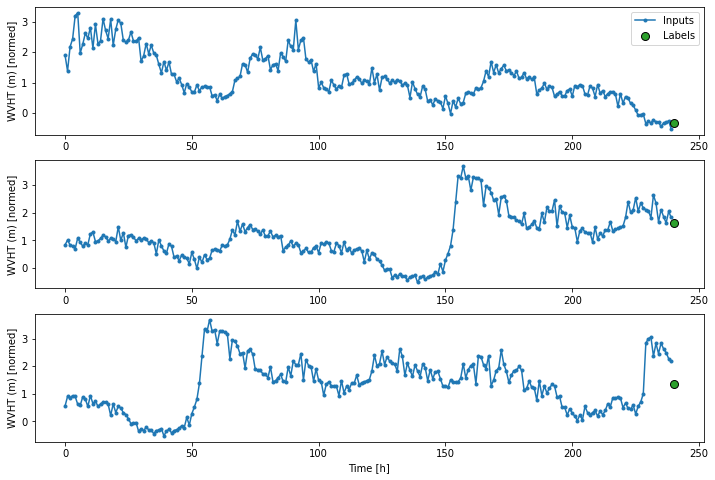

In [ ]:
## This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

w2.plot()



In [ ]:
## You can plot the other columns, but the example window w2 configuration only has labels for the 
## T (degC) column.

w2.plot(plot_col='WSPD (m/s)')



KeyError: ignored

<Figure size 864x576 with 0 Axes>

In [ ]:
##### 4. Create tf.data.Datasets
## Finally, this make_dataset method will take a time series DataFrame and convert it to a 
## tf.data.Dataset of (input_window, label_window) pairs using the 
## tf.keras.utils.timeseries_dataset_from_array function:

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset



In [1]:
## The WindowGenerator object holds training, validation, and test data.

## Add properties for accessing them as tf.data.Datasets using the make_dataset 
## method you defined earlier. Also, add a standard example batch for easy access 
## and plotting:

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example



NameError: ignored

In [ ]:
## Now, the WindowGenerator object gives you access to the tf.data.Dataset objects, 
## so you can easily iterate over the data.

## The Dataset.element_spec property tells you the structure, data types, and shapes 
## of the dataset elements.

# Each element is an (inputs, label) pair.

w2.train.element_spec


In [ ]:
## Iterating over a Dataset yields concrete batches:

for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')




In [ ]:
## Single step models

## The simplest model you can build on this sort of data is one that predicts a single 
## feature's value—1 time step (one hour) into the future based only on the current conditions.

## So, start by building models to predict the WVHT (m) value one hour into the future.

## Configure a WindowGenerator object to produce these single-step (input, label) pairs:

single_step_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['WVHT (m)'])

single_step_window



In [ ]:
## The window object creates tf.data.Datasets from the training, validation, and test sets, 
## allowing you to easily iterate over batches of data.

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')



In [ ]:
### Baseline

## Before building a trainable model it would be good to have a performance baseline 
## as a point for comparison with the later more complicated models.

## This first task is to predict temperature one hour into the future, given the current 
## value of all features. The current values include the current temperature.

## So, start with a model that just returns the current temperature as the prediction, 
## predicting "No change". This is a reasonable baseline since temperature changes slowly. 

## Of course, this baseline will work less well if you make a prediction further in the future.

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]



In [ ]:
## Instantiate and evaluate this model:

baseline = Baseline(label_index=column_indices['WVHT (m)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)




In [ ]:
## That printed some performance metrics, but those don't give you a feeling for how well 
## the model is doing.

## The WindowGenerator has a plot method, but the plots won't be very interesting with only 
## a single sample.

## So, create a wider WindowGenerator that generates windows 24 hours of consecutive inputs 
## and labels at a time. The new wide_window variable doesn't change the way the model operates. 
## The model still makes predictions one hour into the future based on a single input time step. 
## Here, the time axis acts like the batch axis: each prediction is made independently with no 
## interaction between time steps:

wide_window = WindowGenerator(
    input_width=72, label_width=72, shift=1,
    label_columns=['WVHT (m)'])


wide_window



In [ ]:
## This expanded window can be passed directly to the same baseline model without any code changes. 
## This is possible because the inputs and labels have the same number of time steps, and the baseline 
## just forwards the input to the output:

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)



In [ ]:
## By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

wide_window.plot(baseline)

